In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto.csv')
print("df_under is the oversample data frame\n", data.rate.value_counts().sort_index())

df_under is the oversample data frame
 1    261
2    261
3    261
4    261
5    261
Name: rate, dtype: int64


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [4]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2409
RMSE: 0.8265
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2351
RMSE: 0.7745
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2306
RMSE: 0.7867
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2458
RMSE: 0.8361
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2326
RMSE: 0.7514
###############################################
The Results are: 

Average RMSE on Training Set: 0.23700086391762626
Average RMSE on Test Set: 0.7950390895095506
RMSE: 0.8408
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8408451796307033
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8408
MAE:  0.4570
MSE: 0.7070
Precision: 0.15
Recall: 0.13
the acc is 67.82


/tmp/ipykernel_5394/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [5]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2022
RMSE: 0.7369
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2039
RMSE: 0.7667
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2083
RMSE: 0.6876
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1989
RMSE: 0.8479
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2038
RMSE: 0.8102
###############################################
The Results are: 

Average RMSE on Training Set: 0.2034061983067647
Average RMSE on Test Set: 0.7698578921423606
RMSE: 0.8335
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8335351649231405
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8335
MAE:  0.4531
MSE: 0.6948
Precision: 0.22
Recall: 0.16
the acc is 67.82


/tmp/ipykernel_5394/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [6]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2192
RMSE: 0.7778
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1826
RMSE: 0.8025
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2178
RMSE: 0.7675
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2174
RMSE: 0.7871
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2233
RMSE: 0.8028
###############################################
The Results are: 

Average RMSE on Training Set: 0.21206721174612878
Average RMSE on Test Set: 0.7875567996209938


/tmp/ipykernel_5394/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


RMSE: 0.8061
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8061015535628879
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8061
MAE:  0.4853
MSE: 0.6498
Precision: 0.13
Recall: 0.10
the acc is 63.22


/tmp/ipykernel_5394/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [7]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1680
RMSE: 0.8707
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1787
RMSE: 0.9031
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2122
RMSE: 0.7598
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1805
RMSE: 0.8091
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2026
RMSE: 0.6532
###############################################
The Results are: 

Average RMSE on Training Set: 0.188390234656857
Average RMSE on Test Set: 0.799184749455283
RMSE: 0.7037
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7036890909220237
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7037
MAE:  0.3710
MSE: 0.4952
Precision: 0.23
Recall: 0.15
the acc is 71.26


/tmp/ipykernel_5394/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [8]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1276
RMSE: 0.7871
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1351
RMSE: 0.7788
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0876
RMSE: 0.8377
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1311
RMSE: 0.7410
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1232
RMSE: 0.7224
###############################################
The Results are: 

Average RMSE on Training Set: 0.12091436021127269
Average RMSE on Test Set: 0.7734126332913233
RMSE: 0.7910
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7909748964891283
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7910
MAE:  0.4516
MSE: 0.6256
Precision: 0.15
Recall: 0.12
the acc is 64.37


/tmp/ipykernel_5394/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0858
RMSE: 0.6852
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0752
RMSE: 0.7978
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0835
RMSE: 0.7962
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0758
RMSE: 0.7233
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0806
RMSE: 0.8863
###############################################
The Results are: 

Average RMSE on Training Set: 0.08019607323450002
Average RMSE on Test Set: 0.7777839438661106
RMSE: 0.7975
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7974630120923967
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7975
MAE:  0.4095
MSE: 0.6359
Precision: 0.20
Recall: 0.13
the acc is 70.50


/tmp/ipykernel_5394/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0884
RMSE: 0.8681
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1437
RMSE: 0.6928
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1400
RMSE: 0.7829
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0918
RMSE: 0.7765
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1375
RMSE: 0.8790
###############################################
The Results are: 

Average RMSE on Training Set: 0.12028511883522922
Average RMSE on Test Set: 0.7998625010562547
RMSE: 0.8435
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8434538660601886
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5394/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1026
RMSE: 0.7533
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1032
RMSE: 0.8341
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1070
RMSE: 0.7538
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1057
RMSE: 0.7214
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1063
RMSE: 0.7824
###############################################
The Results are: 

Average RMSE on Training Set: 0.10495932536247958
Average RMSE on Test Set: 0.7689969702818601
RMSE: 0.7372
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7371955366979407
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5394/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [12]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2350
RMSE: 0.7872
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2351
RMSE: 0.7418
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2399
RMSE: 0.7761
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2319
RMSE: 0.8283
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2251
RMSE: 0.8047
###############################################
The Results are: 

Average RMSE on Training Set: 0.23339662158676747
Average RMSE on Test Set: 0.7876051202402959
RMSE: 0.7476
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7475876589777366
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7476
MAE:  0.3986
MSE: 0.5589
Precision: 0.20
Recall: 0.18
the acc is 71.26


/tmp/ipykernel_5394/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [13]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2029
RMSE: 0.8799
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2039
RMSE: 0.7319
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2223
RMSE: 0.7814
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2067
RMSE: 0.7933
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2234
RMSE: 0.7177
###############################################
The Results are: 

Average RMSE on Training Set: 0.2118631638396391
Average RMSE on Test Set: 0.7808482501641437
RMSE: 0.7851
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.785054229945165
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7851
MAE:  0.4343
MSE: 0.6163
Precision: 0.25
Recall: 0.18
the acc is 68.20


/tmp/ipykernel_5394/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [14]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2109
RMSE: 0.7249
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2362
RMSE: 0.8125
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2328
RMSE: 0.8245
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2273
RMSE: 0.7699
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2214
RMSE: 0.8334
###############################################
The Results are: 

Average RMSE on Training Set: 0.2257349767705255
Average RMSE on Test Set: 0.7930424707216601
RMSE: 0.7845
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7844788266798574
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7845
MAE:  0.4415
MSE: 0.6154
Precision: 0.18
Recall: 0.13
the acc is 66.28


/tmp/ipykernel_5394/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [15]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2093
RMSE: 0.7778
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2075
RMSE: 0.6436
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1995
RMSE: 0.7917
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1986
RMSE: 0.7777
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1716
RMSE: 0.8643
###############################################
The Results are: 

Average RMSE on Training Set: 0.19729734920977632
Average RMSE on Test Set: 0.7710403047515622
RMSE: 0.8155
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.815548684349026
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8155
MAE:  0.4555
MSE: 0.6651
Precision: 0.19
Recall: 0.12
the acc is 67.05


/tmp/ipykernel_5394/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [16]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1284
RMSE: 0.7639
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1243
RMSE: 0.7744
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0811
RMSE: 0.8624
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1304
RMSE: 0.8138
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1252
RMSE: 0.7867
###############################################
The Results are: 

Average RMSE on Training Set: 0.1178723356563685
Average RMSE on Test Set: 0.8002288604057561
RMSE: 0.7133
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7133466769497782
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7133
MAE:  0.3720
MSE: 0.5089
Precision: 0.19
Recall: 0.16
the acc is 70.50


/tmp/ipykernel_5394/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [17]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1193
RMSE: 0.6936
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1257
RMSE: 0.7223
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0869
RMSE: 0.8043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0865
RMSE: 0.8110
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1310
RMSE: 0.7727
###############################################
The Results are: 

Average RMSE on Training Set: 0.10984890694174068
Average RMSE on Test Set: 0.7607805538907868
RMSE: 0.8115
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8114575286124664
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8115
MAE:  0.4423
MSE: 0.6585
Precision: 0.16
Recall: 0.10
the acc is 67.05


/tmp/ipykernel_5394/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0795
RMSE: 0.7466
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1112
RMSE: 0.7774
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0797
RMSE: 0.7747
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0941
RMSE: 0.8201
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0996
RMSE: 0.7731
###############################################
The Results are: 

Average RMSE on Training Set: 0.09281209958465082
Average RMSE on Test Set: 0.7783923622805178
RMSE: 0.9162
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9161944151007055
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5394/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0939
RMSE: 0.7600
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0993
RMSE: 0.7512
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0912
RMSE: 0.7952
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1093
RMSE: 0.7789
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0991
RMSE: 0.7724
###############################################
The Results are: 

Average RMSE on Training Set: 0.0985724032459961
Average RMSE on Test Set: 0.77152999724563
RMSE: 0.7790
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7789878989368155
Computing the pearson_baseline similarity matrix...

/tmp/ipykernel_5394/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5394/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
3,4,KnnWithMeans,MSD,SGD,False,0.703689,0.371008,0.495178,0.232143,0.148916,71.264368
12,13,KnnWithMeans,pearson corr coeff,ALS,True,0.713347,0.372023,0.508863,0.193548,0.157539,70.498084
7,8,KnnWithMeans,(shrunk) pearson corr coeff,SGD,False,0.737196,0.382397,0.543457,0.221675,0.136741,68.965517
8,9,KnnWithMeans,Cosine,ALS,True,0.747588,0.398606,0.558887,0.199085,0.180692,71.264368
15,16,KnnWithMeans,(shrunk) pearson corr coeff,ALS,False,0.778988,0.428789,0.606822,0.169271,0.117386,67.049808
10,11,KnnWithMeans,MSD,ALS,True,0.784479,0.441522,0.615407,0.182179,0.134259,66.283525
9,10,KnnWithMeans,Cosine,ALS,False,0.785054,0.434260,0.616310,0.251613,0.182456,68.199234
4,5,KnnWithMeans,pearson corr coeff,SGD,True,0.790975,0.451563,0.625641,0.154106,0.117435,64.367816
5,6,KnnWithMeans,pearson corr coeff,SGD,False,0.797463,0.409532,0.635947,0.201389,0.134189,70.498084
2,3,KnnWithMeans,MSD,SGD,True,0.806102,0.485310,0.649800,0.129798,0.098550,63.218391


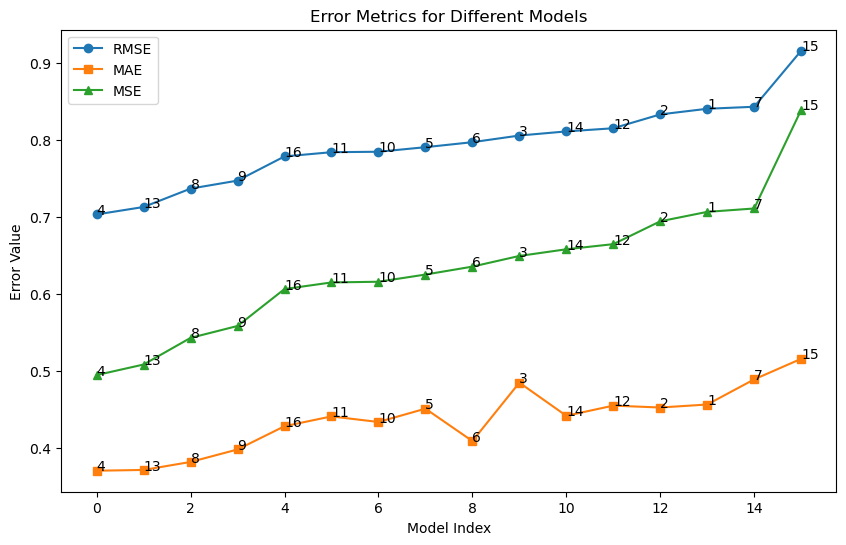

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

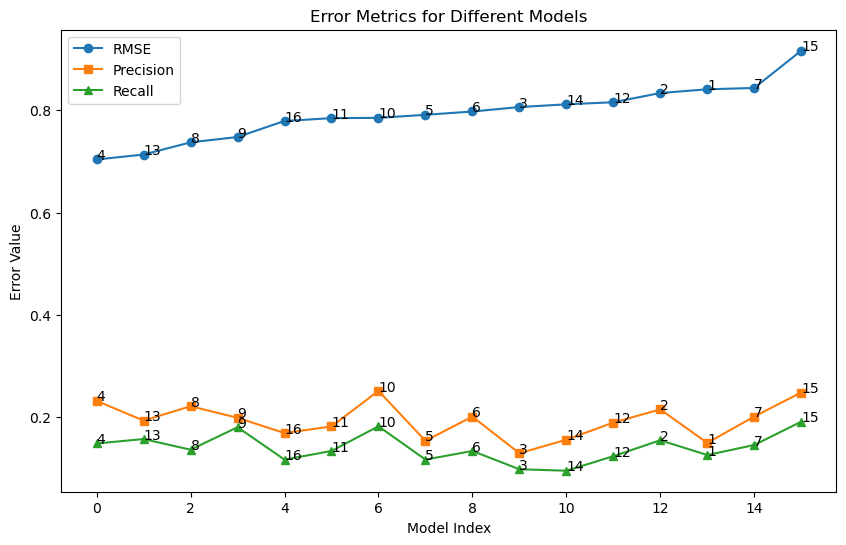

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

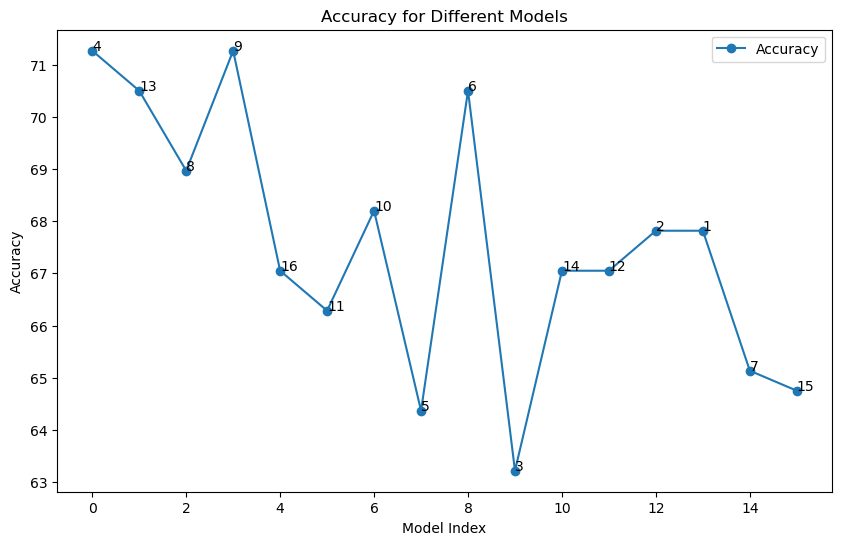

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Fleurie Grand Pre
2. Item ID: Quintessence Montagny 1er Cru
3. Item ID: Anjou Blanc
4. Item ID: Meursault 'Les Grands Charrons'
5. Item ID: Mercurey 'Clos les Bussières' 
6. Item ID: Beyerskloof Western Cape
7. Item ID: Cirus Madiran
8. Item ID: Beyerskloof Western Cape
9. Item ID: Beyerskloof Western Cape
10. Item ID: Beyerskloof Western Cape


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['4ed273f7-1816-4f36-88c7-789125f011c7',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 '8764df8a-0919-433c-beab-053a9c12f402',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 '7e32fee4-f7c4-4600-8a34-db7801ac79d5',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 'dcd16582-14d2-4e00-a024-9b5886d29b29',
 'bc79b0e3-064d-4240-86de-e86499f577e8',
 '5ccd8030-047b-432c-a630-d784ab415756']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['tonel 14',
 'Amarone',
 'Charlotte Rosé',
 'Spätburgunder Rosé',
 'Pinot Grigio',
 'Kellermeister Barossa Vineyards',
 'Brunello di Montlcino Mozard',
 '2/5 大亂鬥 2',
 'Corvina ',
 "Nero d'Avola Sicilia"]

In [28]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 11 with sim 0.000000000000000
user 11 with sim 0.000000000000000
user 11 with sim 0.000000000000000
user 11 with sim 0.000000000000000
user 11 with sim 0.000000000000000
And the baseline estimate is: 1.2755439414632685

#####

Note: If the baseline is 2.9940191387559807 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Aspromonte,5.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",39,2,1.970096
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Gavi Masera,3.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",111,1,0.029904
2,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.000000,"{'actual_k': 40, 'was_impossible': False}",129,110,0.000000
3,5ccd8030-047b-432c-a630-d784ab415756,Acinaia,2.0,2.000000,"{'actual_k': 40, 'was_impossible': False}",73,20,0.000000
4,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.000000,"{'actual_k': 37, 'was_impossible': False}",39,21,0.000000
5,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Corvina,2.0,2.011906,"{'actual_k': 40, 'was_impossible': False}",111,12,0.011906
6,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Rosso d’Asia,3.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",111,2,0.029904
7,5ccd8030-047b-432c-a630-d784ab415756,Dettelbach Silvaner,3.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",73,1,0.029904
8,3b1f7bc8-6a23-47e5-97df-043bd1b97f12,Bardolino,2.0,2.055556,"{'actual_k': 7, 'was_impossible': False}",10,10,0.055556
9,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Traminer Komjanc,3.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",129,0,0.029904


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
67,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",129,110,0.0
174,990f0572-c5e7-47ec-ba20-141ab6058369,Omega Rosso,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",3,2,0.0
88,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",129,110,0.0
243,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,"""PG Rosa"" Pinot grigio",2.0,2.0,"{'actual_k': 40, 'was_impossible': False}",129,19,0.0
85,00324bc3-0b35-4051-bc6d-9c258a4252c2,Cavalcaonte Barbera Forlí,5.0,5.0,"{'actual_k': 26, 'was_impossible': False}",19,18,0.0
178,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",129,110,0.0
83,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",129,110,0.0
82,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",44,44,0.0
180,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Blancs,5.0,5.0,"{'actual_k': 38, 'was_impossible': False}",111,15,0.0
80,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",44,44,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
204,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",0,18,1.970096
103,99654a70-c3bb-46f4-8697-b9345482e48d,Cabernet Sauvignon,3.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",2,6,2.000000
96,91cf68cc-9436-43e1-871d-33beef4d2337,Riesling,3.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",35,1,2.000000
123,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Merlot,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",52,4,2.000000
177,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.029904
46,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",9,1,2.029904
198,4ed273f7-1816-4f36-88c7-789125f011c7,Moscato d'Asti,1.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",11,2,2.029904
240,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.029904
146,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Merlot le vigne di zamo,1.0,3.029904,"{'was_impossible': True, 'reason': 'User and/o...",129,0,2.029904
151,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,1.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",44,2,3.000000
